In [207]:
import pickle
from caiman.base.rois import register_multisession
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf.utilities import detrend_df_f
from caiman.source_extraction.cnmf import params as params
from caiman.utils import visualization
from caiman.utils.utils import download_demo
from caiman.utils.utils import load_dict_from_hdf5
from caiman.utils.utils import recursively_load_dict_contents_from_group
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys
from skimage import io
import time
import h5py
import os
import math
import cv2
import re
import scipy
from matplotlib.cm import get_cmap
import seaborn as sns

## read CNMF hdf5 filenames

In [208]:
filedir = 'D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1'
filenames = []
file_index = []
for dirpath, dirnames, files in os.walk(filedir): # can walk through all levels down
    #     print(f'Found directory: {dirpath}')
    for f_name in files:
        if f_name.endswith('.hdf5'):
            filename = dirpath+'/'+f_name
            try:
                index = list(map(int,re.findall(r"(\d{4,5})",f_name)))[0]
                filenames.append(filename)
                file_index.append(index)

            except:
                pass
reindex = np.argsort(file_index)
sort_file_index = np.sort(file_index)

sort_filenames = [filenames[i] for i in reindex]
print('---------------------------------------------')    
print('Files have been loaded.')
sort_filenames    

---------------------------------------------
Files have been loaded.


['D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0001_03-10-14-07_cond.hdf5',
 'D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0002_03-11-12-19_cond.hdf5',
 'D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0003_03-12-16-00_cond.hdf5',
 'D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0004_03-12-22-59_cond.hdf5',
 'D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0005_03-13-11-59_cond.hdf5',
 'D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0006_03-14-18-49_deg.hdf5',
 'D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0008_03-15-23-44_deg.hdf5',
 'D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0009_03-16-14-00_deg.hdf5',
 'D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/00010_03-17-12-58_deg.hdf5']

## load CNMF data and add to lists

In [209]:
spatial = []
F_dff   = []
YrA     = []
C       = []
b = []
f = []
S = []
denoised_dff = []
for filename in sort_filenames:
    Dict = load_dict_from_hdf5(filename)
    spatial.append(Dict['estimates']['A'])
    F_dff.append(Dict['estimates']['F_dff'])
    YrA.append(Dict['estimates']['YrA'])
    C.append(Dict['estimates']['C'])
    b.append(Dict['estimates']['b'])
    f.append(Dict['estimates']['f'])
    S.append(Dict['estimates']['S'])
    
    good_F_df = detrend_df_f(Dict['estimates']['A'], Dict['estimates']['b'], Dict['estimates']['C'], Dict['estimates']['f'],
                             Dict['estimates']['YrA']*0.08, quantileMin=8, frames_window=1000, flag_auto=True, 
                             use_fast=False, detrend_only=False)
    denoised_dff.append(good_F_df)

## Load behavioral and imaging pickled dataframes

In [210]:
def pickle_dict(df,path,filename):
    try:
        os.makedirs(path) # create the path first
    except FileExistsError:
        print('the path exist.')
    filename = path +'/{}.pickle'.format(filename)
    with open(filename, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('save to pickle done!')


def load_pickleddata(filename):
    
    with open(filename, 'rb') as handle:
        df = pickle.load(handle)
    return df
def getKeys(dict): 
    list = [] 
    for key in dict.keys(): 
        list.append(key) 
    return list
def find_align_position(framenum_trialtype,frameswitch_trialtype):
    pre = []
    post = []
    for i in range(len(framenum_trialtype)):
        pre_temp = frameswitch_trialtype[i][0]
        post_temp = framenum_trialtype[i] - pre_temp
        pre.append(pre_temp)
        post.append(post_temp)
    max_pre = np.max(pre)
    max_post = np.max(post)
    len_nan = int(max_pre+max_post+1)
    return max_pre, max_post,len_nan

def subtract_baseline(stacked_matrix,soleopen_frame):
    
    sub = stacked_matrix.copy()
    for i in range(stacked_matrix.shape[0]):
        value = sub[i,0:int(soleopen_frame)]
        
        if len(value) >1:
            avg = value.mean()
            
        else:
            avg = 0
        
        sub[i,:] =  sub[i,:] - avg
        
    return sub

def create_3d_matrix(num_neurons, len_nan, num_go, odor_on_frame, temp_traces, 
                     index_trialtype, framenum_trialtype,frameswitch_trialtype): 
    ### for the xxx_trialtype, the type has to be specified when give inputs
    a = np.full([num_neurons, len_nan, num_go], np.nan)
    
    for i, index in enumerate(index_trialtype):
        start_p = int(odor_on_frame-frameswitch_trialtype[i][0])
        end_p = int(start_p + framenum_trialtype[i])
        sub = subtract_baseline(temp_traces['Trial{}'.format(index)], frameswitch_trialtype[i][0])
        
        a[:,start_p:end_p,i] = sub
    return a
 

def slice_signal_to_trial(temp_traces,df): 
    # signal matrix: neurons * temporal traces; frames: the colomn for frame length, df.frame
    F_dff_individualtrials = {}
    cum_frames = np.cumsum(df.frames.values)
    cum_frames = np.insert(cum_frames, 0,0)
    for i in range(len(cum_frames)-1):
        F_dff_individualtrials['Trial'+str(i)] = temp_traces[:,cum_frames[i]:cum_frames[i+1]].copy()
        
    return F_dff_individualtrials

def generate_aligned_matrix(Dict,F_dff,trialtype = 'go'):
    multi_soleopen_frame = []
    aligned_multi_F_dff_list = []
    for i,big_dict in enumerate(Dict):
        
        df_original = big_dict['behavior_original_df']
        df_all_drop = big_dict['behavior_dropped_df']
        F_dff_individual_trials = big_dict['temp_traces_trial_dict']
        dict_index_trialtype = big_dict['dict_index_trialtype']
        dict_framenum_trialtype = big_dict['dict_framenum_trialtype']
        
        dict_frameswitch_trialtype = big_dict['dict_frameswitch_trialtype']
        print(getKeys(dict_index_trialtype)) 
        trialtype = input('trialtype: (type none if pass) ')
        if trialtype == 'none':
            aligned_multi_F_dff_list.append(None)
            multi_soleopen_frame.append(None)
            continue
        index_trialtype = dict_index_trialtype[trialtype] 
        framenum_trialtype = dict_framenum_trialtype[trialtype] 
        frameswitch_trialtype = dict_frameswitch_trialtype[trialtype] 

        odor_on_frame,max_post_odor_frame,len_nan = find_align_position(framenum_trialtype,frameswitch_trialtype)
        num_go = len(framenum_trialtype)
        
        num_neurons = F_dff[i].shape[0]
        temp_traces_dict = slice_signal_to_trial(F_dff[i],df_original)

        order = np.argsort(index_trialtype)
        index_trialtype = np.sort(index_trialtype)
        framenum_trialtype = [ framenum_trialtype[i] for i in order]
        frameswitch_trialtype = [ frameswitch_trialtype[i] for i in order]
        F_dff_matrix = create_3d_matrix(num_neurons, len_nan, num_go, odor_on_frame, temp_traces_dict, index_trialtype, framenum_trialtype,frameswitch_trialtype)
        aligned_multi_F_dff_list.append(F_dff_matrix)
        multi_soleopen_frame.append(odor_on_frame)
    return aligned_multi_F_dff_list,multi_soleopen_frame


## Create multiplt aligned df/f matrix for each session (list format - neurons x time x trials)

In [211]:
# Dict for all sessions of behavioral dicts
Dict = []
for filename in sort_filenames:
    big_dict = load_pickleddata(filename[:-5]+'.pickle')
    Dict.append(big_dict)
    print(filename[:-5]+'.pickle loaded')

D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0001_03-10-14-07_cond.pickle loaded
D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0002_03-11-12-19_cond.pickle loaded
D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0003_03-12-16-00_cond.pickle loaded
D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0004_03-12-22-59_cond.pickle loaded
D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0005_03-13-11-59_cond.pickle loaded
D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0006_03-14-18-49_deg.pickle loaded
D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0008_03-15-23-44_deg.pickle loaded
D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/0009_03-16-14-00_deg.pickle loaded
D:/PhD/Microscope/Selina/imaging_data/result/OT-GC-1/00010_03-17-12-58_deg.pickle loaded


In [213]:
# baseline has been ssubtracted
aligned_multi_F_dff_go,multi_soleopen_frame_go = generate_aligned_matrix(Dict, denoised_dff, 'go')
print('sessions of go:', len(aligned_multi_F_dff_go))

['go_omit', 'go', 'background', 'no_go']
trialtype: (type none if pass) go
['background', 'no_go', 'go_omit', 'go']
trialtype: (type none if pass) go
['background', 'no_go', 'go', 'go_omit']
trialtype: (type none if pass) go
['go_omit', 'no_go', 'go', 'background']
trialtype: (type none if pass) go
['go_omit', 'go', 'no_go', 'background']
trialtype: (type none if pass) go
['OdorReward', 'NOdorReward', 'NOdorNReward', 'OdorNReward']
trialtype: (type none if pass) OdorReward
['NOdorReward', 'OdorReward', 'OdorNReward', 'NOdorNReward']
trialtype: (type none if pass) OdorReward
['OdorReward', 'OdorNReward', 'NOdorReward', 'NOdorNReward']
trialtype: (type none if pass) OdorReward
['NOdorNReward', 'OdorReward', 'NOdorReward', 'OdorNReward']
trialtype: (type none if pass) OdorReward
sessions of go: 9


In [243]:
nogo_aligned_multi_F_dff,nogo_multi_soleopen_frame = generate_aligned_matrix(Dict, denoised_dff, 'nogo')
print('sessions of no go:', len(nogo_aligned_multi_F_dff))

['go_omit', 'go', 'background', 'no_go']
trialtype: (type none if pass) no_go
['background', 'no_go', 'go_omit', 'go']
trialtype: (type none if pass) no_go
['background', 'no_go', 'go', 'go_omit']
trialtype: (type none if pass) no_go
['go_omit', 'no_go', 'go', 'background']
trialtype: (type none if pass) no_go
['go_omit', 'go', 'no_go', 'background']
trialtype: (type none if pass) no_go
['OdorReward', 'NOdorReward', 'NOdorNReward', 'OdorNReward']
trialtype: (type none if pass) none
['NOdorReward', 'OdorReward', 'OdorNReward', 'NOdorNReward']
trialtype: (type none if pass) none
['OdorReward', 'OdorNReward', 'NOdorReward', 'NOdorNReward']
trialtype: (type none if pass) none
['NOdorNReward', 'OdorReward', 'NOdorReward', 'OdorNReward']
trialtype: (type none if pass) none
sessions of no go: 9


In [244]:
goomit_aligned_multi_F_dff,goomit_multi_soleopen_frame = generate_aligned_matrix(Dict, denoised_dff, 'go_omit')
print('sessions of go omit:', len(goomit_aligned_multi_F_dff))

['go_omit', 'go', 'background', 'no_go']
trialtype: (type none if pass) go_omit
['background', 'no_go', 'go_omit', 'go']
trialtype: (type none if pass) go_omit
['background', 'no_go', 'go', 'go_omit']
trialtype: (type none if pass) go_omit
['go_omit', 'no_go', 'go', 'background']
trialtype: (type none if pass) go_omit
['go_omit', 'go', 'no_go', 'background']
trialtype: (type none if pass) go_omit
['OdorReward', 'NOdorReward', 'NOdorNReward', 'OdorNReward']
trialtype: (type none if pass) OdorNReward
['NOdorReward', 'OdorReward', 'OdorNReward', 'NOdorNReward']
trialtype: (type none if pass) OdorNReward
['OdorReward', 'OdorNReward', 'NOdorReward', 'NOdorNReward']
trialtype: (type none if pass) OdorNReward
['NOdorNReward', 'OdorReward', 'NOdorReward', 'OdorNReward']
trialtype: (type none if pass) OdorNReward
sessions of go omit: 9


In [214]:
### in conditioning days, background cannot be used!!!! put none for condition day background. cannot be aligned
bg_aligned_multi_F_dff,bg_multi_soleopen_frame = generate_aligned_matrix(Dict, denoised_dff, 'background')
print('sessions of background:', len(bg_aligned_multi_F_dff))

['go_omit', 'go', 'background', 'no_go']
trialtype: (type none if pass) none
['background', 'no_go', 'go_omit', 'go']
trialtype: (type none if pass) none
['background', 'no_go', 'go', 'go_omit']
trialtype: (type none if pass) none
['go_omit', 'no_go', 'go', 'background']
trialtype: (type none if pass) none
['go_omit', 'go', 'no_go', 'background']
trialtype: (type none if pass) none
['OdorReward', 'NOdorReward', 'NOdorNReward', 'OdorNReward']
trialtype: (type none if pass) NOdorReward
['NOdorReward', 'OdorReward', 'OdorNReward', 'NOdorNReward']
trialtype: (type none if pass) NOdorReward
['OdorReward', 'OdorNReward', 'NOdorReward', 'NOdorNReward']
trialtype: (type none if pass) NOdorReward
['NOdorNReward', 'OdorReward', 'NOdorReward', 'OdorNReward']
trialtype: (type none if pass) NOdorReward
sessions of background: 9


## get number of trials and mean and standard deviation of each neuron for each session

In [215]:
def mean_std_n_of_multidff(aligned_multi_F_dff):  
    mean = []
    std = []
    n = []
    for matrix in aligned_multi_F_dff:
        mean_act = np.nanmean(matrix,axis = 2)
        n_trials = matrix.shape[2]
        std_act = np.nanstd(matrix,axis = 2)
        mean.append(mean_act)
        std.append(std_act)
        n.append(n_trials)
    return mean,std,n

In [216]:
go_mean_multi, go_std_multi, go_n_multi = mean_std_n_of_multidff(aligned_multi_F_dff_go)
# nogo_mean_multi, nogo_std_multi, nogo_n_multi = mean_std_n_of_multidff(nogo_aligned_multi_F_dff)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [217]:
go_mean_multi[0].shape

(68, 51)

# let's test PCA


In [219]:
# load data
align_dff = aligned_multi_F_dff_go[8]
odor_on_frame = multi_soleopen_frame_go[8]
num_neuron = align_dff.shape[0]
timepoints = 30
num_trials = align_dff.shape[2]
# reshape data array into [# neurons] * [#trials x # timepoints(-5:30)]
reshape_dff = np.zeros([int(num_neuron),int(timepoints*num_trials)])
for i in range(num_trials):
    copy = align_dff[:,odor_on_frame :odor_on_frame+30, i]
    reshape_dff[:,30*i:30*i+30] = copy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

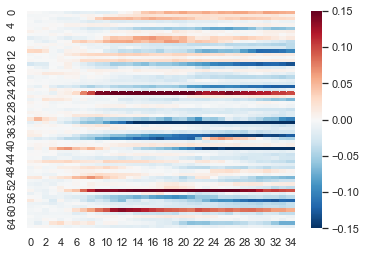

In [221]:
# try to use mean rather than stacked trials
reshape_dff = go_mean_multi[8][:,odor_on_frame-5:odor_on_frame+30]
# plot data matrix
sns.heatmap(reshape_dff,vmin = -0.15, vmax = 0.15,cmap = 'RdBu_r')
sum(np.isnan(reshape_dff))

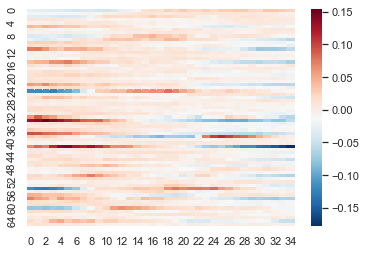

In [222]:
# center the data
avg = np.mean(reshape_dff,axis = 1)
centered_dff = (reshape_dff.copy().T-avg).T
centered_dff.shape
# plot data matrix
sns.heatmap(centered_dff,cmap = 'RdBu_r')

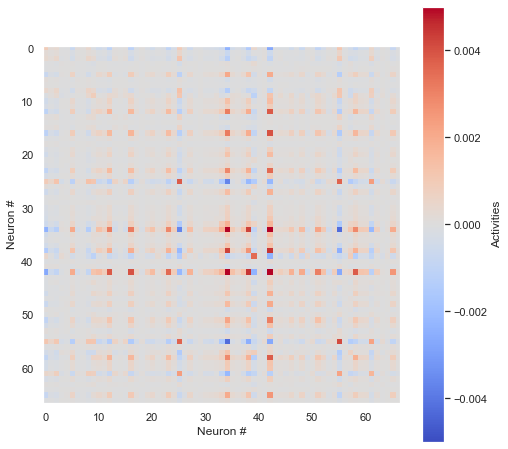

In [223]:
# compute and plot the covariance matrix
import matplotlib as mpl
sns.set()
fig,ax = plt.subplots(figsize=(8,8))

covarience = np.cov(centered_dff)

c = ax.imshow(covarience,vmin = -0.005, vmax = 0.005,cmap = 'coolwarm')

ax.set_ylabel('Neuron #')
ax.set_xlabel('Neuron #')
ax.grid(False)
cb = fig.colorbar(c)
cb.set_label('Activities')

plt.show()

In [224]:
# determine eigenvalue and eigenvector of the matrix
eigenvalue,eigenvec = np.linalg.eigh(covarience)
print('What is the shape of your eigenvector matrix? How many eigenvalues do you get?')
print('There are', eigenvalue.shape[0],' eigenvalues.')
print('The shape of the eigenvector is',eigenvec.shape,'.')

What is the shape of your eigenvector matrix? How many eigenvalues do you get?
There are 67  eigenvalues.
The shape of the eigenvector is (67, 67) .


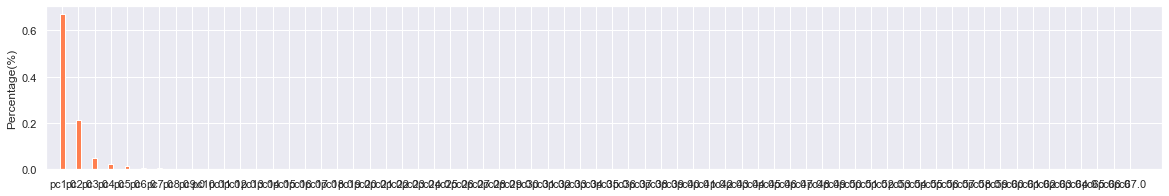

In [225]:
# sort eigenvalue and eigenvector as ascending order
sort_index = np.argsort(-eigenvalue)
eigenvec = eigenvec[:,sort_index]
eigenvalue = eigenvalue[sort_index]
# plot eigenvalues
sns.set()
fig,ax = plt.subplots(figsize=(20,3))
x = np.linspace(1,eigenvalue.shape[0],eigenvalue.shape[0])
plt.bar(x,eigenvalue/np.sum(eigenvalue),width = 0.3,color = 'coral')
plt.xlim([0,eigenvalue.shape[0]+2])
plt.xticks(x, ('pc{}'.format(i) for i in x))
plt.ylabel('Percentage(%)')

plt.show()

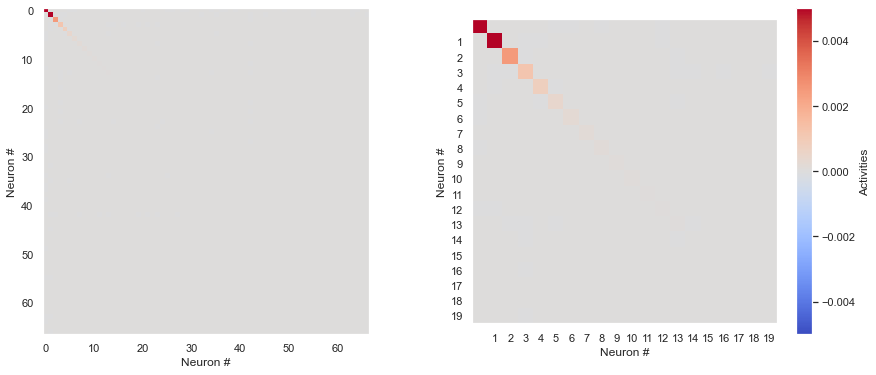

In [226]:
# rotate the matrix according to PCA axis
centered_dff_rotated = eigenvec.T.dot(centered_dff)

#plot the new covarience matrix
centered_dff_rotated_cov = np.cov(centered_dff_rotated)
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,6))
c = ax1.imshow(centered_dff_rotated_cov ,vmin=-0.005, vmax=0.005,cmap = 'coolwarm')

ax1.set_ylabel('Neuron #')
ax1.set_xlabel('Neuron #')
ax1.grid(False)
cb = fig.colorbar(c)
cb.set_label('Activities')
ax2.imshow(centered_dff_rotated_cov[0:20,0:20],vmin=-0.005, vmax=0.005,cmap = 'coolwarm')
ax2.set_ylabel('Neuron #')
ax2.set_xlabel('Neuron #')
ax2.grid(False)
tick = range(1,20,1)
ax2.set_xticks(tick)
ax2.set_yticks(tick)
plt.show()

Text(0, 0.5, 'Response')

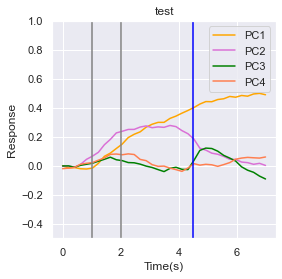

In [246]:
# project data onto first and second principal component
first_eigen = eigenvec[:,0]
second_eigen = eigenvec[:,1]
third_eigen = eigenvec[:,2]
forth_eigen = eigenvec[:,3]
first_proj = first_eigen.T.dot(reshape_dff)
second_proj = second_eigen.T.dot(reshape_dff)
third_proj = third_eigen.T.dot(reshape_dff)
forth_proj = forth_eigen.T.dot(reshape_dff)

plt.figure(figsize = (4,4))
plt.subplot(111,)

x = np.linspace(0,7,35)
plt.plot(x,-first_proj,color='orange',label = 'PC1')
plt.plot(x,-second_proj,color='orchid',label = 'PC2')
plt.plot(x,-third_proj,color='green',label = 'PC3')
plt.plot(x,forth_proj,color='coral',label = 'PC4')
# plt.plot(x,-first_proj-second_proj,color='purple',label = 'PC1+2')
# plt.plot(x,-first_proj-second_proj-third_proj,color='red',label = 'PC1+2+3')


plt.axvline(x=1,color = 'grey')
plt.axvline(x=2,color = 'grey')
plt.axvline(x=4.5,color = 'blue')

plt.legend()
plt.ylim([-0.5,1])
plt.title('test')
plt.xlabel('Time(s)')
plt.ylabel('Response')

In [237]:
corr_1 = np.dot(-first_proj.T,np.asarray(reshape_dff).T)/np.sqrt(sum(first_proj**2))
corr_2 = np.dot(-second_proj.T,np.asarray(reshape_dff).T)/np.sqrt(sum(second_proj**2))
corr_3 = np.dot(-third_proj.T,np.asarray(reshape_dff).T)/np.sqrt(sum(third_proj**2))
# corr_12 = np.dot((-first_proj-second_proj).T,np.asarray(centered_dff).T)/np.sqrt(sum((first_proj-second_proj)**2)*np.sum(np.asarray(centered_dff)**2,axis = 1))

# label = np.zeros(num_neuron)
# label[corr_1>0.76] = 1
# label[corr_1<-0.6] = 2
# label[corr_1>0.94] = 3


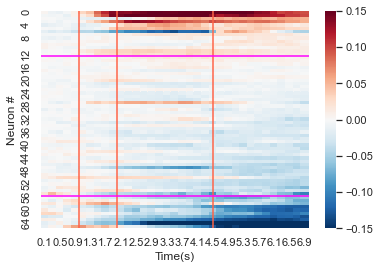

In [238]:
fig,ax2 = plt.subplots()

order = np.argsort(-corr_1)
sns.heatmap(reshape_dff[order,:],vmin = -0.15, vmax = 0.15,cmap = 'RdBu_r')

line1 = sum(corr_2>0.05)
line2 = num_neuron-sum(corr_2<-0.02)

ax2.axvline(x=5,color = 'tomato')
ax2.axvline(x=10,color = 'tomato')
ax2.axvline(x=22.5,color = 'tomato')
ax2.axhline(y=line1,color = 'magenta')
ax2.axhline(y=line2,color = 'magenta')

a = ax2.get_xticks()
a = a/5
ax2.set_xticklabels(a)

ax2.set_ylabel('Neuron #')
ax2.set_xlabel('Time(s)')

plt.show()

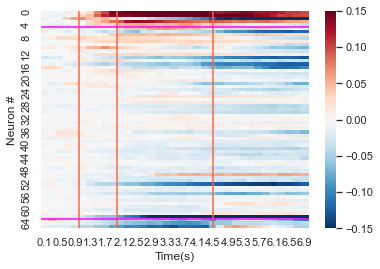

In [242]:
fig,ax2 = plt.subplots()

order = np.argsort(-corr_2)
sns.heatmap(reshape_dff[order,:],vmin = -0.15, vmax = 0.15,cmap = 'RdBu_r')
line1 = sum(corr_2>0.1)
line2 = num_neuron-sum(corr_2<-0.05)

ax2.axvline(x=5,color = 'tomato')
ax2.axvline(x=10,color = 'tomato')
ax2.axvline(x=22.5,color = 'tomato')
ax2.axhline(y=line1,color = 'magenta')
ax2.axhline(y=line2,color = 'magenta')

a = ax2.get_xticks()
a = a/5
ax2.set_xticklabels(a)

ax2.set_ylabel('Neuron #')
ax2.set_xlabel('Time(s)')

plt.show()

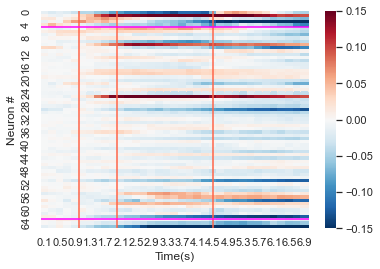

In [243]:
fig,ax2 = plt.subplots()

order = np.argsort(-corr_3)
sns.heatmap(reshape_dff[order,:],vmin = -0.15, vmax = 0.15,cmap = 'RdBu_r')
line1 = sum(corr_2>0.1)
line2 = num_neuron-sum(corr_2<-0.05)

ax2.axvline(x=5,color = 'tomato')
ax2.axvline(x=10,color = 'tomato')
ax2.axvline(x=22.5,color = 'tomato')
ax2.axhline(y=line1,color = 'magenta')
ax2.axhline(y=line2,color = 'magenta')

a = ax2.get_xticks()
a = a/5
ax2.set_xticklabels(a)

ax2.set_ylabel('Neuron #')
ax2.set_xlabel('Time(s)')

plt.show()

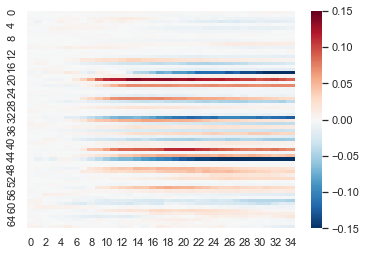

In [151]:
order = np.argsort(-corr_3)
sns.heatmap(reshape_dff[order,:],vmin = -0.15, vmax = 0.15,cmap = 'RdBu_r')

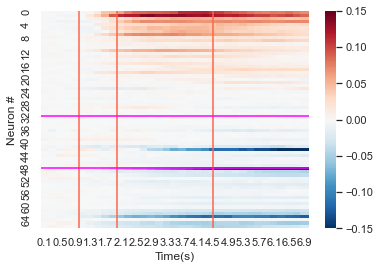

In [162]:
fig,ax2 = plt.subplots()

order = np.argsort(-corr_12)
sns.heatmap(reshape_dff[order,:],vmin = -0.15, vmax = 0.15,cmap = 'RdBu_r')

line1 = sum(corr_2>0.1)
line2 = num_neuron-sum(corr_2<-0.05)

ax2.axvline(x=5,color = 'tomato')
ax2.axvline(x=10,color = 'tomato')
ax2.axvline(x=22.5,color = 'tomato')
ax2.axhline(y=line1,color = 'magenta')
ax2.axhline(y=line2,color = 'magenta')

a = ax2.get_xticks()
a = a/5
ax2.set_xticklabels(a)

ax2.set_ylabel('Neuron #')
ax2.set_xlabel('Time(s)')

plt.show()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

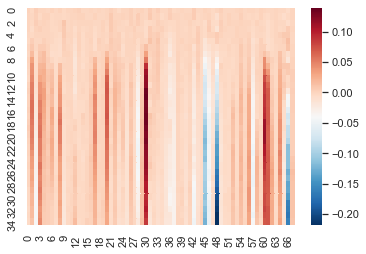

In [170]:
# 
# try to use mean rather than stacked trials
reshape_dff = mean_multi[0][:,odor_on_frame-5:odor_on_frame+30]
reshape_dff = reshape_dff.T
# plot data matrix
sns.heatmap(reshape_dff,cmap = 'RdBu_r')
sum(np.isnan(reshape_dff))

In [175]:
avg

array([ 2.94834683e-04,  6.07415747e-05, -2.41538921e-04, -4.61088347e-04,
       -1.57886080e-04, -3.39514578e-04, -5.28540864e-04, -1.86753006e-04,
        9.95974184e-04,  2.64163854e-03,  3.49064345e-03,  4.05971684e-03,
        4.49394728e-03,  4.77747059e-03,  4.68772262e-03,  4.20605778e-03,
        3.83684438e-03,  3.61756729e-03,  3.97208848e-03,  3.04652003e-03,
        2.39449410e-03,  1.54296191e-03,  6.46643309e-04,  6.74658101e-04,
        3.34491552e-04,  3.25699023e-04, -7.79866965e-04, -1.42329716e-03,
       -2.52218792e-03, -2.80229632e-03, -3.67606197e-03, -4.37805018e-03,
       -4.80558431e-03, -5.52260479e-03, -5.69064255e-03])

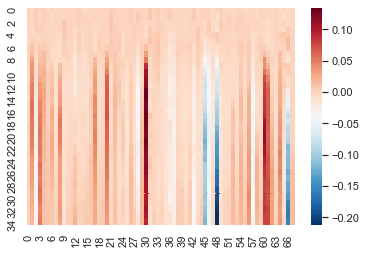

In [174]:
# center the data
avg = np.mean(reshape_dff,axis = 1)
centered_dff = (reshape_dff.copy().T-avg).T
centered_dff.shape
# plot data matrix
sns.heatmap(centered_dff,cmap = 'RdBu_r')

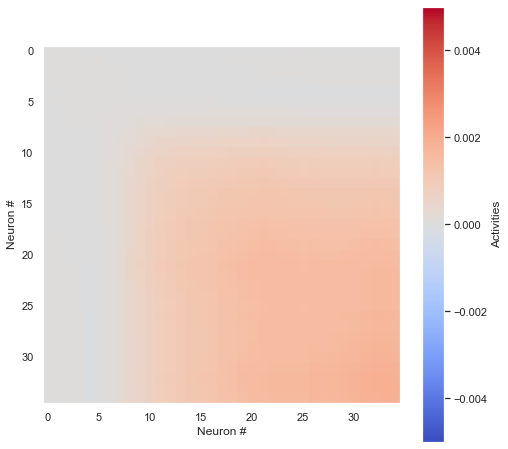

In [176]:
# compute and plot the covariance matrix
import matplotlib as mpl
sns.set()
fig,ax = plt.subplots(figsize=(8,8))

covarience = np.cov(centered_dff)

c = ax.imshow(covarience,vmin = -0.005, vmax = 0.005,cmap = 'coolwarm')

ax.set_ylabel('Neuron #')
ax.set_xlabel('Neuron #')
ax.grid(False)
cb = fig.colorbar(c)
cb.set_label('Activities')

plt.show()

In [177]:
# determine eigenvalue and eigenvector of the matrix
eigenvalue,eigenvec = np.linalg.eigh(covarience)
print('What is the shape of your eigenvector matrix? How many eigenvalues do you get?')
print('There are', eigenvalue.shape[0],' eigenvalues.')
print('The shape of the eigenvector is',eigenvec.shape,'.')

What is the shape of your eigenvector matrix? How many eigenvalues do you get?
There are 35  eigenvalues.
The shape of the eigenvector is (35, 35) .


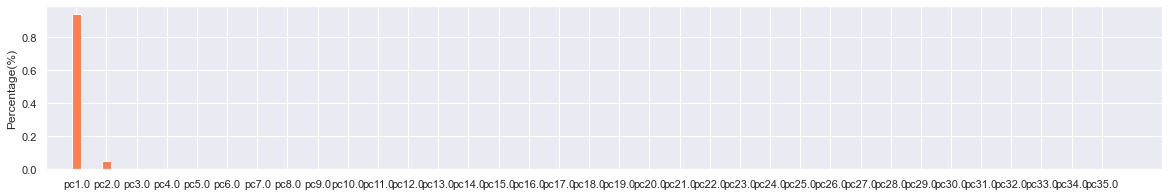

In [178]:
# sort eigenvalue and eigenvector as ascending order
sort_index = np.argsort(-eigenvalue)
eigenvec = eigenvec[:,sort_index]
eigenvalue = eigenvalue[sort_index]
# plot eigenvalues
sns.set()
fig,ax = plt.subplots(figsize=(20,3))
x = np.linspace(1,eigenvalue.shape[0],eigenvalue.shape[0])
plt.bar(x,eigenvalue/np.sum(eigenvalue),width = 0.3,color = 'coral')
plt.xlim([0,eigenvalue.shape[0]+2])
plt.xticks(x, ('pc{}'.format(i) for i in x))
plt.ylabel('Percentage(%)')

plt.show()

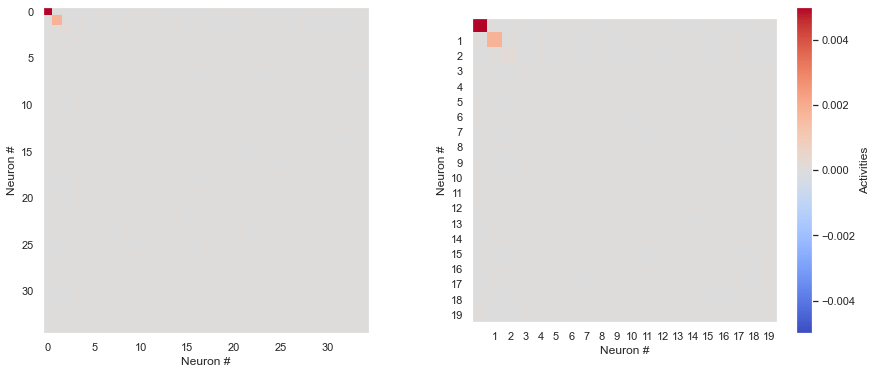

In [179]:
# rotate the matrix according to PCA axis
centered_dff_rotated = eigenvec.T.dot(centered_dff)

#plot the new covarience matrix
centered_dff_rotated_cov = np.cov(centered_dff_rotated)
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,6))
c = ax1.imshow(centered_dff_rotated_cov ,vmin=-0.005, vmax=0.005,cmap = 'coolwarm')

ax1.set_ylabel('Neuron #')
ax1.set_xlabel('Neuron #')
ax1.grid(False)
cb = fig.colorbar(c)
cb.set_label('Activities')
ax2.imshow(centered_dff_rotated_cov[0:20,0:20],vmin=-0.005, vmax=0.005,cmap = 'coolwarm')
ax2.set_ylabel('Neuron #')
ax2.set_xlabel('Neuron #')
ax2.grid(False)
tick = range(1,20,1)
ax2.set_xticks(tick)
ax2.set_yticks(tick)
plt.show()

Text(0, 0.5, 'PC2')

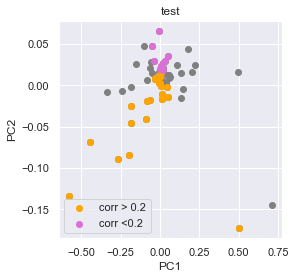

In [204]:
# project data onto first and second principal component
first_eigen = eigenvec[:,0]
second_eigen = eigenvec[:,1]
third_eigen = eigenvec[:,2]
forth_eigen = eigenvec[:,3]
first_proj = first_eigen.T.dot(centered_dff)
second_proj = second_eigen.T.dot(centered_dff)
third_proj = third_eigen.T.dot(centered_dff)
forth_proj = forth_eigen.T.dot(centered_dff)

plt.figure(figsize = (4,4))
plt.subplot(111,)

x = np.linspace(0,7,35)
plt.scatter(first_proj,-second_proj,color='grey')
plt.scatter(first_proj[corr_2>0.2],-second_proj[corr_2>0.2],color='orange',label = 'corr > 0.2')
plt.scatter(first_proj[corr_2<-0.2],-second_proj[corr_2<-0.2],color='orchid',label = 'corr <0.2')



plt.legend(loc=3)

plt.title('test')
plt.xlabel('PC1')
plt.ylabel('PC2')

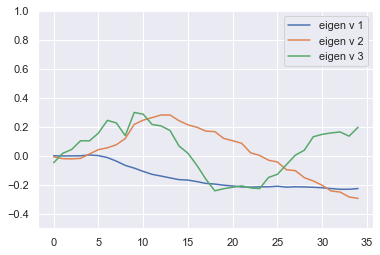

In [196]:
plt.plot(eigenvec[:,0],label = 'eigen v 1')
plt.plot(eigenvec[:,1],label = 'eigen v 2')
plt.plot(eigenvec[:,2],label = 'eigen v 3')
plt.ylim([-0.5,1])
plt.legend()

Text(0, 0.5, 'Response')

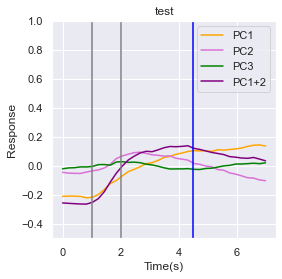

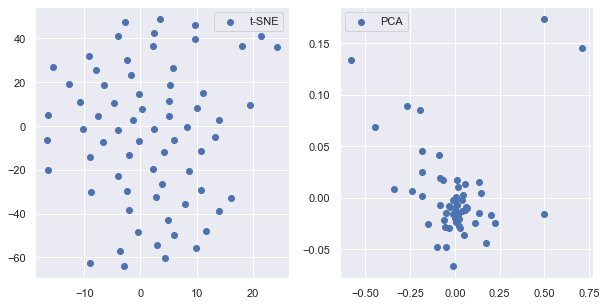

In [201]:
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os


X_tsne = TSNE(n_components=2,random_state=33).fit_transform(centered_dff.T)
X_pca = PCA(n_components=2).fit_transform(centered_dff.T)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], label="t-SNE")
plt.legend()
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], label="PCA")
plt.legend()

plt.show()

In [199]:
from sklearn.datasets import load_iris,load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [267]:
sns.reset_orig()

In [244]:
# mean activity plot
for i in range(len(sort_file_index)):
    reshape_dff = go_mean_multi[i][:,odor_on_frame-5:odor_on_frame+30]
    # plot data matrix
    sns.heatmap(reshape_dff,vmin = -0.15, vmax = 0.15,cmap = 'RdBu_r')

array([ 1,  2,  3,  4,  5,  6,  8,  9, 10])

In [311]:
def pc_plot(mean_multi_dff_matrix,multi_soleopen_frame,session_index,is_plot=False,name = 'test'):

    first_eigen_list=[]
    second_eigen_list=[]
    third_eigen_list=[]
    forth_eigen_list=[]
    fig,ax = plt.subplots(2,len(session_index),figsize = (34,8))
    axes = fig.add_axes([.91, 0.15, .01, 0.7])
    for i in range(len(session_index)):
        
        odor_on_frame = multi_soleopen_frame[i]
        reshape_dff = mean_multi_dff_matrix[i][:,int(odor_on_frame-5):int(odor_on_frame+30)]
        # center the data
        avg = np.mean(reshape_dff,axis = 1)
        centered_dff = (reshape_dff.copy().T-avg).T    
        # compute covariance matrix
        covarience = np.cov(centered_dff)
        # determine eigenvalue and eigenvector of the matrix
        eigenvalue,eigenvec = np.linalg.eigh(covarience)
        # sort eigenvalue and eigenvector as ascending order
        sort_index = np.argsort(-eigenvalue)
        eigenvec = eigenvec[:,sort_index]
        eigenvalue = eigenvalue[sort_index]
        # project data onto first and second principal component
        first_eigen = eigenvec[:,0]
        second_eigen = eigenvec[:,1]
        third_eigen = eigenvec[:,2]
        forth_eigen = eigenvec[:,3]
        first_proj = first_eigen.T.dot(reshape_dff)
        index = np.argmax(np.abs(first_proj[5:20]))
        if first_proj[5:20][index]<0:
            first_proj = -first_proj
        second_proj = second_eigen.T.dot(reshape_dff)
        index = np.argmax(np.abs(second_proj[5:20]))
        if second_proj[5:20][index]<0:
            second_proj = -second_proj
        third_proj = third_eigen.T.dot(reshape_dff)
        index = np.argmax(np.abs(third_proj[22:30]))
        if third_proj[22:30][index]<0:
            third_proj = -third_proj
        forth_proj = forth_eigen.T.dot(reshape_dff)
        index = np.argmax(np.abs(forth_proj[22:30]))
        if forth_proj[22:30][index]<0:
            forth_proj = -forth_proj
        first_eigen_list.append(first_proj)
        second_eigen_list.append(second_proj)
        third_eigen_list.append(third_proj)
        forth_eigen_list.append(forth_proj)
        if is_plot:
            # plot eigenvalues
             
            x = np.linspace(1,4,4)
            ax[1,i].bar(x,eigenvalue[0:4]/np.sum(eigenvalue),width = 0.3,color = ['purple','orange','green','orchid'])
            ax[1,i].set_xlim([0,1])
            ax[1,i].set_xlim([0,4+2])
            ax[1,i].set_xticks(x)
            ax[1,i].set_xticklabels('pc{}'.format(j+1) for j in range(4))
            
            ax[1,i].set_ylabel('Percentage(%)' if i == 0 else '',fontsize = 16)


            x = np.linspace(0,7,35)
            index = np.argmax(np.abs(first_proj))
            if first_proj[index]<0:
                first_proj = -first_proj
            ax[0,i].plot(x,first_proj,color='purple',label = 'PC1')
            ax[0,i].plot(x,second_proj,color='orange',label = 'PC2')
            ax[0,i].plot(x,third_proj,color='green',label = 'PC3')
            ax[0,i].plot(x,forth_proj,color='orchid',label = 'PC4')
            # plt.plot(x,-first_proj-second_proj,color='purple',label = 'PC1+2')
            # plt.plot(x,-first_proj-second_proj-third_proj,color='red',label = 'PC1+2+3')

            # decoration
            ax[0,i].fill_between([1,2], [100,100],[-100,-100],facecolor="grey", color='grey', alpha=0.1)   
            # lick shaded area
            ax[0,i].fill_between([4.5,4.58], [100,100],[-100,-100],facecolor="#3083D1", color='#3083D1',alpha=0.2)


            
            ax[0,i].set_ylim([-0.3,1])
            ax[0,i].set_title('Session {}'.format(session_index[i]),fontsize = 16)
            ax[0,i].set_xlabel('Time(s)',fontsize = 16)
            ax[0,i].set_ylabel('PC Response'if i ==0 else '',fontsize = 16)
            ax[0,i].set_yticks([-0.3,0,0.3,0.6,0.9])
            ax[0,i].set_yticklabels(['-0.3','0','0.3','0.6','0.9'])
            if i == 0:
                handles, labels = ax[0,i].get_legend_handles_labels()
                axes.legend(handles, labels,loc='center left',frameon=False,fontsize = 16)
                
            axes.tick_params(axis="both", which="both", labelleft=False,labelbottom=False,bottom=False, left = False, top = False, right = False)
            axes.spines["top"].set_visible(False)    
            axes.spines["right"].set_visible(False)
            axes.spines["bottom"].set_visible(False)    
            axes.spines["left"].set_visible(False)
    plt.savefig("{}.png".format(name), bbox_inches="tight", dpi = 400)
    return  first_eigen_list,second_eigen_list,third_eigen_list,forth_eigen_list

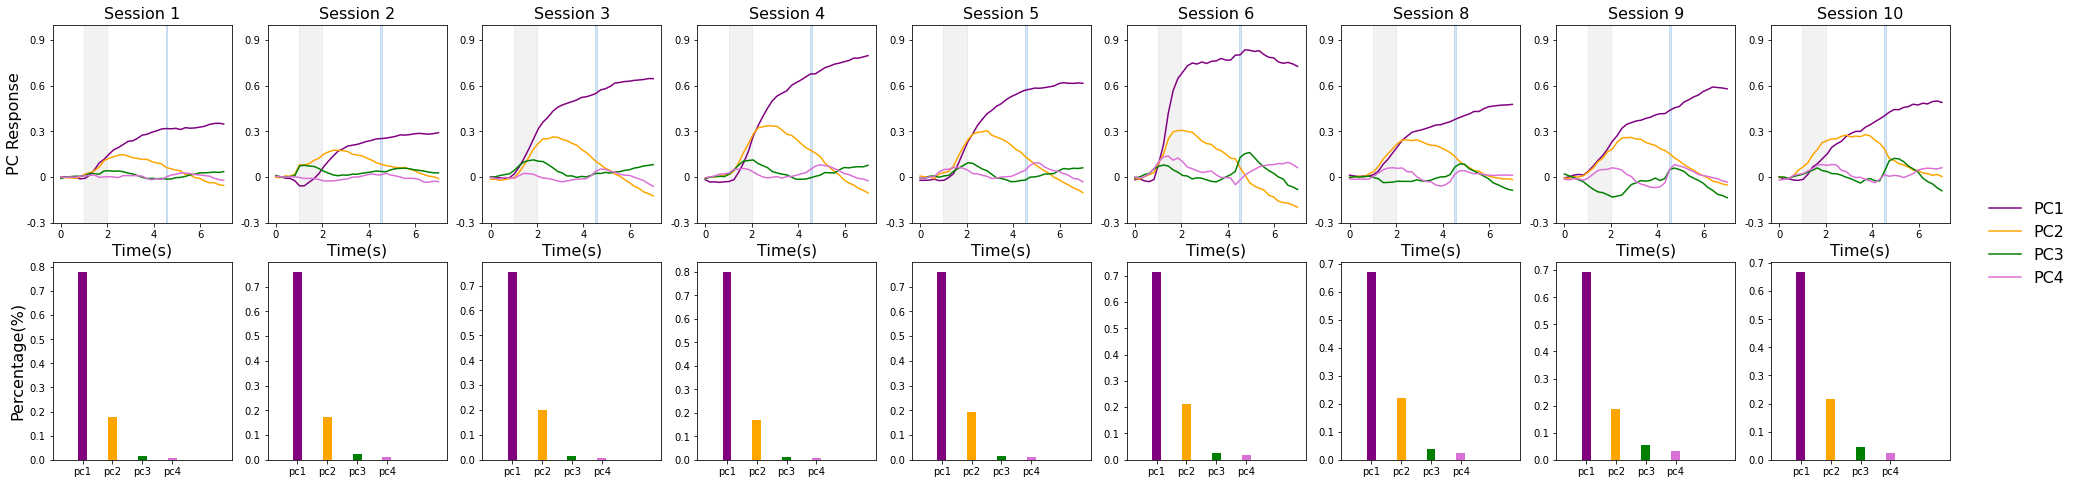

In [437]:
savename = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1-new/PCA_go_mean_9session'
first_eigen_list,second_eigen_list,third_eigen_list,forth_eigen_list = pc_plot(go_mean_multi,multi_soleopen_frame_go,
                                                                               session_index=sort_file_index,is_plot = True,name = savename)

## fluctuation of response within a session

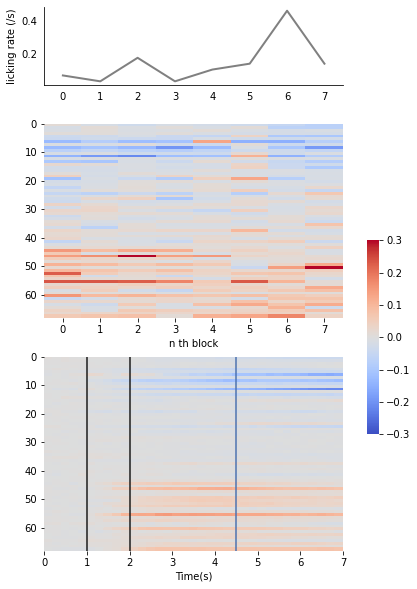

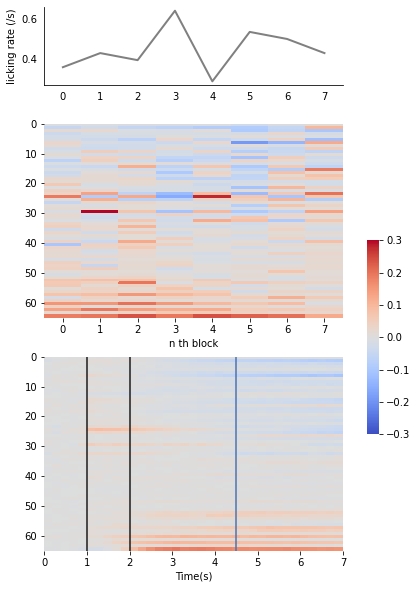

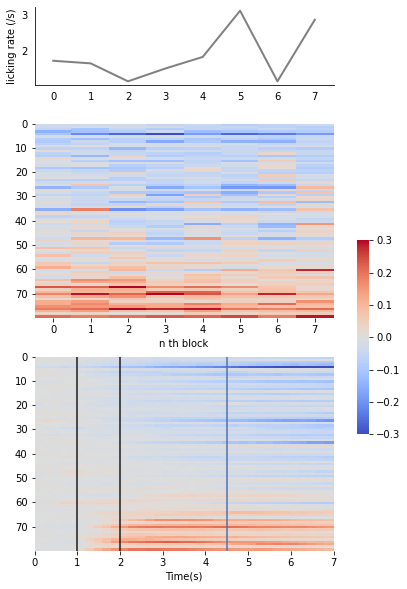

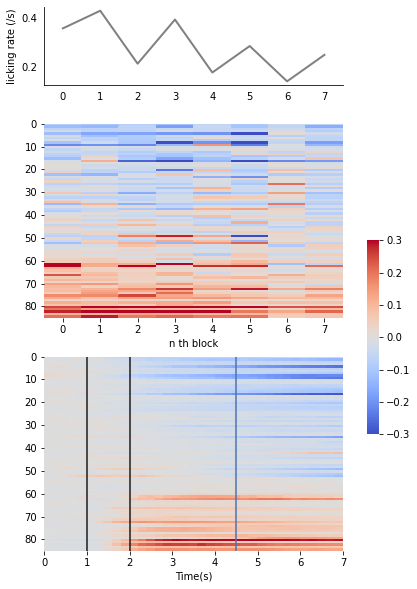

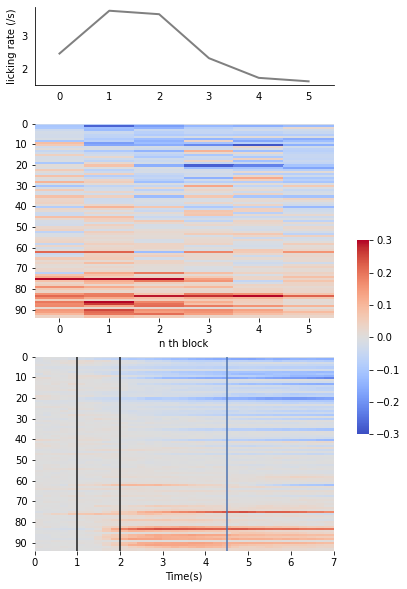

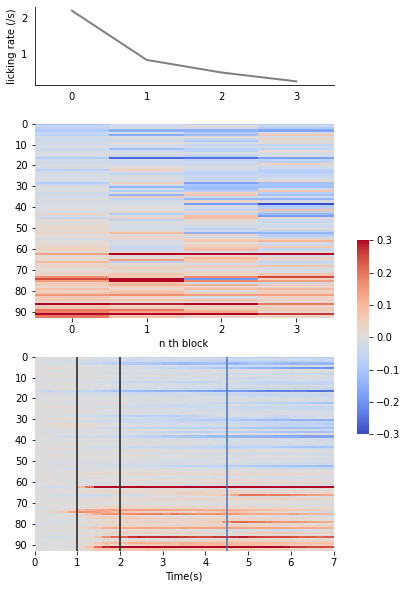

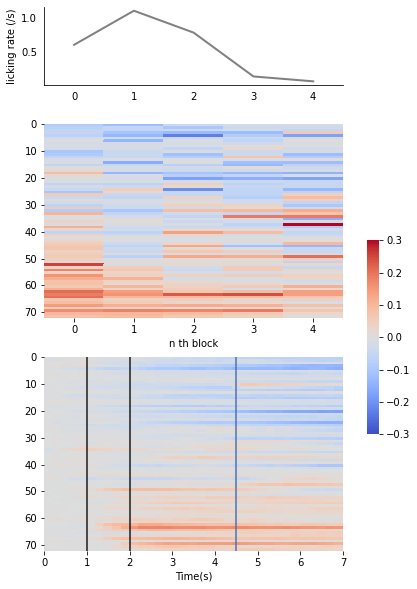

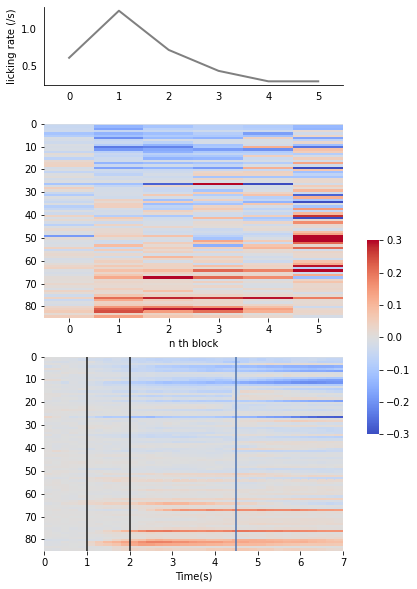

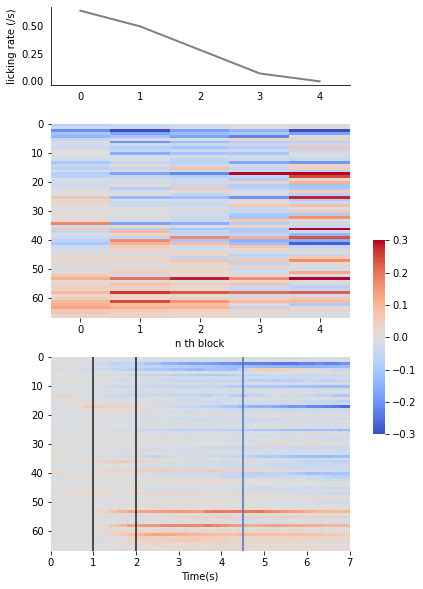

In [435]:
for index in range(len(aligned_multi_F_dff_go)):
    dff_matrix = aligned_multi_F_dff_go[index]
    new_matrix  = np.zeros([dff_matrix.shape[0],int(np.ceil(dff_matrix.shape[2]/8))])
    odor_on_frame = multi_soleopen_frame_go[index]
    block_width = 8
    for i in range(int(np.ceil(dff_matrix.shape[2]/block_width))):
        cell = dff_matrix[:,int(odor_on_frame):int(odor_on_frame+17),i*block_width:min((i+1)*block_width,dff_matrix.shape[2])].copy()
        mean_cell = np.nanmean(cell,axis = 2)
        peak_index = np.argmax(np.abs(mean_cell),axis = 1)
        for j in range(dff_matrix.shape[0]):
            new_matrix[j,i] = mean_cell[j,peak_index[j]]



    big_dict = Dict[index]
    df_all_drop = big_dict['behavior_dropped_df']
    
    if index <= 4:
        index_trialtype = big_dict['dict_index_trialtype']['go']
    else:
        index_trialtype = big_dict['dict_index_trialtype']['OdorReward']
    licking_time = df_all_drop.loc[index_trialtype,'licking'].tolist()
    beh_odor_time = df_all_drop.loc[index_trialtype,'go_odor_on'].tolist()


    lick_times = np.zeros([len(index_trialtype)]) # licking rate in 3.5s anticipatory licking window
    window = 3.5
    for i in range(len(index_trialtype)):
        x = [ant for ant in licking_time[i] if ant > beh_odor_time[i][0] and ant < beh_odor_time[i][0]+window]
        lick_times[i] = len(x)/window

    new_array = np.zeros(int(np.ceil(len(lick_times)/8)))
    for i in range(int(np.ceil(len(lick_times)/8))):
        mean_lick = np.mean(lick_times[i*8:min((i+1)*8,len(lick_times))].copy())
        new_array[i] = mean_lick
    corr = np.dot(new_array,new_matrix.T,)/np.sqrt(np.sum((new_array)**2)*np.sum(np.asarray(new_matrix)**2,axis = 1))
    order = np.argsort(corr)

    fig = plt.figure(figsize=(6, 10))
    col = 10
    odor_on_frame = int(multi_soleopen_frame_go[index])
    grid = plt.GridSpec(5, col, hspace=0.5, wspace=2)
    main_ax = fig.add_subplot(grid[1:3,0:col-1])
    lick_ax = fig.add_subplot(grid[0,0:col-1], xticklabels=[], sharex=main_ax)
    mean_ax = fig.add_subplot(grid[3:5,0:col-1], yticklabels=[])
    legend_ax = fig.add_subplot(grid[2:4, col-1])


    # scatter points on the main axes
    x = np.linspace(0,len(new_array)-1,len(new_array))+0.5
    lick_ax.plot(x,new_array,color = 'grey',linewidth = 2)
    lick_ax.set_ylabel('licking rate (/s)')
    sns.heatmap(new_matrix[order,:],cmap = 'coolwarm',vmin = -0.3,vmax = 0.3,ax = main_ax,cbar_ax=legend_ax)  
    sns.heatmap(go_mean_multi[index][order,odor_on_frame-5:odor_on_frame+30],cmap = 'coolwarm',vmin = -0.3,vmax = 0.3,ax = mean_ax,cbar_ax=legend_ax)




    lick_ax.tick_params(axis="both", which="both", bottom=False, left = False, top = False, right = False) 
    lick_ax.spines["top"].set_visible(False)    
    lick_ax.spines["right"].set_visible(False)
    num_ticks = 10
    # the index of the position of yticks
    yticks = range(0, new_matrix.shape[0] - 1, 10)
    yticklabels = [str(y) for y in yticks]
    xticks = range(0, 40, 5)
    xticklabels = [str(int(y/5)) for y in xticks]
    main_ax.set_yticks(yticks)
    main_ax.set_yticklabels(yticklabels)
    main_ax.set_xlabel('n th block')
    mean_ax.set_yticks(yticks)
    mean_ax.set_yticklabels(yticklabels)
    mean_ax.set_xticks(xticks)
    mean_ax.set_xticklabels(xticklabels)
    mean_ax.axvline(x = 5,color = 'k')
    mean_ax.axvline(x = 10,color = 'k')
    mean_ax.axvline(x = 22.5,color = 'b')
    mean_ax.set_xlabel('Time(s)')
    # lick_ax.spines["bottom"].set_visible(False)    
    # lick_ax.spines["left"].set_visible(False)
    name = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1-new/000{}_blockby8_lick_neuroresponse_sortedmeanactivity'.format(sort_file_index[index])
    plt.savefig("{}.png".format(name), bbox_inches="tight", dpi = 200)
    plt.show()


array([ 1,  2,  3,  4,  5,  6,  8,  9, 10])

In [412]:
yticks

array([ 0,  9, 19, 28, 38, 47, 57, 67])